# Média horária de tempo seco

In [1]:
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
# Caminhos dos arquivos Excel
pasta = "C:\\ENS\\LAUTEC"
caminho_arquivo_ee_ponte = pasta+'\\Inputs\\ee_ponte.xlsx' 
caminho_arquivo_ee_rendeiras = pasta+'\\Inputs\\ee_rendeiras.xlsx'
caminho_arquivo_precipitacao = pasta+'\\Outputs\\prec_epagri_corrigido.xlsx' 

In [3]:
# Dados EE
dados_ee_ponte = pd.read_excel(
    caminho_arquivo_ee_ponte, sheet_name='serie').set_index('Data1') 
dados_ee_rendeiras = pd.read_excel(
    caminho_arquivo_ee_rendeiras, sheet_name='serie').set_index('Data1') 
#dados_ee_ponte.info()
#dados_ee_rendeiras.info()

In [4]:
dados_ee_ponte['Data'] = dados_ee_ponte.index.date
dados_ee_rendeiras['Data'] = dados_ee_rendeiras.index.date

In [5]:
# Identificar dias secos
precipitacao = pd.read_excel(caminho_arquivo_precipitacao,
                             index_col=0)
dias_secos = precipitacao.loc[precipitacao['Dia seco']==True].set_index('index')

In [6]:
# Extrair vazões dos dias secos
vazoes_ponte = dados_ee_ponte[dados_ee_ponte['Data'].isin(dias_secos.index.date)] 
vazoes_rendeiras = dados_ee_rendeiras[dados_ee_rendeiras['Data'].isin(dias_secos.index.date)] 

In [7]:
# Média horária
vazoes_ponte = vazoes_ponte.drop('Data', axis='columns').resample('h').mean().dropna(subset='Vazão (L/s)')
vazoes_rendeiras = vazoes_rendeiras.drop('Data', axis='columns').resample('h').mean().dropna(subset='Vazão (L/s)')

In [8]:
vazoes_ponte['Dia'] = vazoes_ponte.index.date
vazoes_ponte = vazoes_ponte.reset_index()

vazoes_rendeiras['Dia'] = vazoes_rendeiras.index.date
vazoes_rendeiras = vazoes_rendeiras.reset_index()

In [9]:
# Função para identificar os períodos de tempo seco 
def periodo(df, coluna='Dia'):
    df['diff'] = df[coluna].diff().fillna(pd.Timedelta(days=0))
    df['Período'] = (df['diff'] > pd.Timedelta(days=1)).cumsum() + 1
    df = df.drop('diff', axis='columns')
    return df 

vazoes_ponte = periodo(vazoes_ponte)
vazoes_rendeiras = periodo(vazoes_rendeiras)

In [10]:
# Agrupar por 'periodo' e obter as datas mínimas e máximas
periodos = vazoes_ponte.groupby('Período')['Dia'].agg(['min', 'max']).reset_index()

# Formatando e imprimindo as informações para cada período
for idx, row in periodos.iterrows():
    print(f"{row['Período']}° período: {row['min'].strftime('%d/%m/%Y')} a {row['max'].strftime('%d/%m/%Y')}") 

1° período: 24/10/2023 a 27/10/2023
2° período: 18/12/2023 a 20/12/2023
3° período: 30/12/2023 a 31/12/2023
4° período: 05/02/2024 a 12/02/2024
5° período: 18/03/2024 a 22/03/2024
6° período: 01/04/2024 a 04/04/2024


In [11]:
# Excluir ano novo e carnaval (3° e 4° períodos)
vazoes_ponte = vazoes_ponte.loc[~(vazoes_ponte['Período']==3)]
vazoes_ponte = vazoes_ponte.loc[~(vazoes_ponte['Período']==4)].reset_index().drop('index', axis='columns')

vazoes_rendeiras = vazoes_rendeiras.loc[~(vazoes_rendeiras['Período']==3)]
vazoes_rendeiras = vazoes_rendeiras.loc[~(vazoes_rendeiras['Período']==4)].reset_index().drop('index', axis='columns')

In [12]:
vazoes_ponte_aux = vazoes_ponte.loc[:, ['Data1','Vazão (L/s)']].set_index('Data1')
vazoes_ponte_aux['Hora'] = vazoes_ponte_aux.index.hour  
vazoes_ponte_aux = vazoes_ponte_aux.groupby('Hora').mean()

vazoes_rend_aux = vazoes_rendeiras.loc[:, ['Data1','Vazão (L/s)']].set_index('Data1')
vazoes_rend_aux['Hora'] = vazoes_rend_aux.index.hour  
vazoes_rend_aux = vazoes_rend_aux.groupby('Hora').mean()

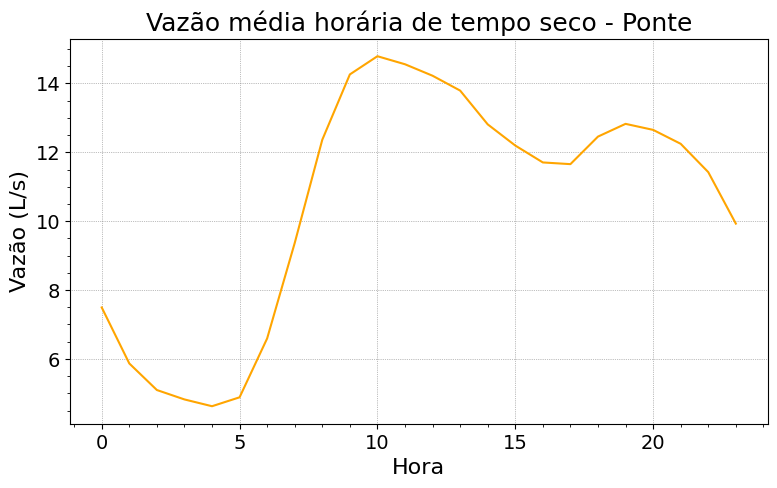

In [14]:
# Gráfico
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(vazoes_ponte_aux.index,
        vazoes_ponte_aux['Vazão (L/s)'],
        color='orange')

plt.title('Vazão média horária de tempo seco - Ponte', size = 18)
plt.xlabel('Hora', 
           size = 16)
plt.ylabel('Vazão (L/s)', size = 16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax.grid(True,
        which='major', 
        color='gray', 
        linestyle=':',
        linewidth=0.5)

ax.minorticks_on()
plt.savefig(pasta+'\\Outputs\\media_tseco_ponte.png', bbox_inches='tight') 

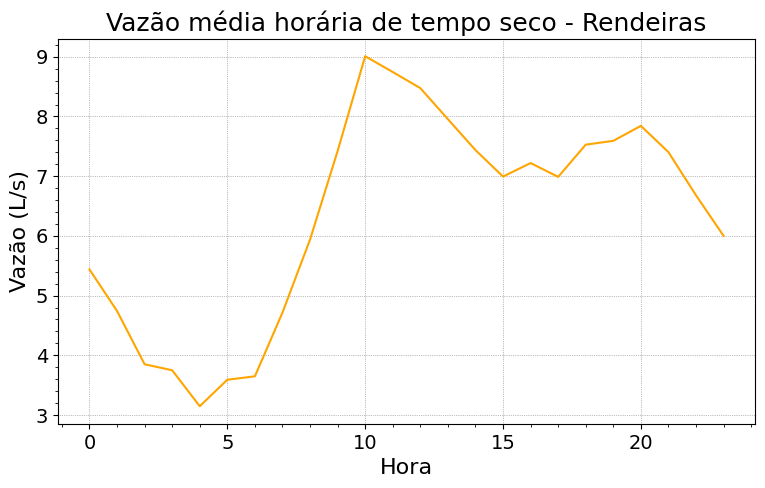

In [15]:
# Gráfico
fig,ax = plt.subplots(figsize=(9,5))
ax.plot(vazoes_rend_aux.index,
        vazoes_rend_aux['Vazão (L/s)'],
        color='orange')

plt.title('Vazão média horária de tempo seco - Rendeiras', size = 18)
plt.xlabel('Hora', 
           size = 16)
plt.ylabel('Vazão (L/s)', size = 16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
ax.grid(True,
        which='major', 
        color='gray', 
        linestyle=':',
        linewidth=0.5)

ax.minorticks_on()
plt.savefig(pasta+'\\Outputs\\media_tseco_rendeiras.png', bbox_inches='tight')

In [16]:
# Salvar planilha
with pd.ExcelWriter(pasta+'\\Outputs\\vazoes_tempo_seco.xlsx') as writer:
    vazoes_ponte.to_excel(writer, sheet_name='Ponte')
    vazoes_ponte_aux.to_excel(writer, sheet_name='ponte1')
    vazoes_rendeiras.to_excel(writer, sheet_name='Rendeiras') 
    vazoes_rend_aux.to_excel(writer, sheet_name='rendeiras1')